<a href="https://colab.research.google.com/github/guihahn/dog-breed-project/blob/master/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
!mkdir data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip -O /content/data/dogImages.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip -O /content/data/lfw.zip
import zipfile
import os

--2020-06-03 02:45:52--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.224
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘/content/data/dogImages.zip’

/content/data/dogIm 100%[===================>]   1.05G  21.5MB/s    in 51s     

2020-06-03 02:46:44 (21.0 MB/s) - ‘/content/data/dogImages.zip’ saved [1132023110/1132023110]

--2020-06-03 02:46:45--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.96
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196739509 (188M) [application/zip]
Saving to: ‘/content/data/lfw.zip’


In [0]:
# Extract zip
os.chdir('/content/data')
for file in os.listdir():
  zip_ref = zipfile.ZipFile(file, 'r')
  zip_ref.extractall()
  zip_ref.close()
os.chdir('/content')
!rm /content/data/*.zip

In [3]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/content/data/lfw/*/*"))
dog_files = np.array(glob("/content/data/dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


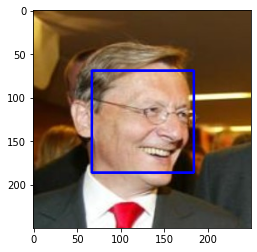

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# load color (BGR) image
img = cv2.imread(human_files[34])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [0]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [0]:
really_human_faces = 0
dog_human_faces = 0

for i in tqdm(range(100)):
    really_human_faces += face_detector(human_files_short[i])
    dog_human_faces += face_detector(dog_files_short[i])

print("\n{}% correct human faces and {}% dog classified as human faces" .format(really_human_faces, dog_human_faces))

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


99% correct human faces and 52% dog classified as human faces


.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [0]:
import torch
import torchvision.models as models

# check if CUDA is available
use_cuda = torch.cuda.is_available()

In [8]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [0]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    # read image and convert to RGB
    image = Image.open(img_path).convert('RGB')
    
    # normalize the input
    normalize = transforms.Compose([
                                    transforms.RandomResizedCrop(224), 
                                    transforms.ToTensor()
                                    ])
    image = normalize(image).unsqueeze(0)

    # If using cuda, tensor to cuda
    if use_cuda:
      image = image.cuda()

    # run model to predict class
    prediction = VGG16(image)

    # If using cuda, return tensor to cpu
    if use_cuda:
      prediction = prediction.cpu()
    
    # convert the probabilities to class labels
    # retrieve the most likely result, e.g. highest probability
    label = prediction.data.numpy().argmax()
        
    return label # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    return VGG16_predict(img_path) in range(151,268) # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [0]:
really_dog_faces = 0
human_dog_faces = 0

for i in tqdm(range(100)):
    human_dog_faces += dog_detector(human_files_short[i])
    really_dog_faces += dog_detector(dog_files_short[i])

print("\n{}% of correct classified dog faces and {}% human faces bad classified as dog faces" .format(really_dog_faces, human_dog_faces))

100%|██████████| 100/100 [00:06<00:00, 14.82it/s]


82% of correct classified dog faces and 1% human faces bad classified as dog faces


.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [0]:
import os
from torchvision import datasets, transforms

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# number of workers of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
train_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])
                                ])

test_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])
                                ])

# choose the training, validation and test datasets
img_dir = '/content/data/dogImages/'

data_scratch = {'train': datasets.ImageFolder(img_dir+'train', transform = train_transform),
                'valid': datasets.ImageFolder(img_dir+'valid', transform = test_transform),
                'test' : datasets.ImageFolder(img_dir+'test', transform = test_transform)}

loaders_scratch = {'train': torch.utils.data.DataLoader(data_scratch['train'], batch_size = batch_size, num_workers = num_workers, shuffle=True),
                   'valid': torch.utils.data.DataLoader(data_scratch['valid'], batch_size = batch_size, num_workers = num_workers),
                   'test' : torch.utils.data.DataLoader(data_scratch['test'],  batch_size = batch_size, num_workers = num_workers)}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

I've applied Resize, Center Crop, Random Horizontal Flip to training data.

For validation and testing data, I've just applied Resize and Center Crop. 

*   **Resize**:  Resize (256) and Center Crop (224) was important to make it easier to compare performance with pre-trained models.

*   **Augmentation**: I've decided to use Data augmentation because it helps to prevent overfitting. I've applied Random Horizontal Flip just to training data.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 2, stride = 2)
        self.conv2 = nn.Conv2d(32, 128, 2,  stride = 2)
        self.conv3 = nn.Conv2d(128, 256, 2, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(56 * 56 * 4, 133)
        
        self.dropout = nn.Dropout(0.8)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = self.dropout(x)
        x = self.fc1(x)
        
        return x

model_scratch = Net()

if use_cuda:
    model_scratch.cuda()

print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(32, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=133, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I've started using 3 Conv2d and 2 Linear layers as follows:

*   Conv2d(3, 16, 3, padding = 1)
*   Conv2d(16, 32, 3, padding = 1)
*   Conv2d(32, 64, 3, padding = 1)
*   MaxPool2d(2,2) after each of Conv2d layers
*   Linear(224 * 224, 1000)
*   Linear(1000, 500)
*   Linear(500, 133)
*   Dropout(p=0.3, inplace=False)

CrossEntropyLoss as Criterion and SGD as Optimizer.
Learning Rate of 0.01

After some training, because my loss was not decreasing I've decided to change some hyperparameters like:
 - Dropping 2nd Linear layer;
 - Trying different learning rates (0.1, 0.01, 0.001, 0.0001);
 - Adjusting out-channels in Conv2d layers (from max 64 to 256 in last layer);
 - Increasing dropout (0.3, 0.4, 0.5, 0.6, 0.8) because it was overfitting too fast;
 - Trying Adam as Optimizer;
 - Adjusting kernels in Conv2d layers (from 3 to 2);
 - Adjusting stride in Conv2d first layers (from 1 to 2) to reduce dimension;
 - Adjusting padding in Conv2d layers (removing 1-padding).
 - Dropping one more Linear layer, keeping just one.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.003)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
import datetime as dt

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradientes of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' % (epoch, batch_idx + 1, train_loss))            
                
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(dt.datetime.now())
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                                                                valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
model_scratch = train(60, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, '/content/model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('/content/model_scratch.pt'))

Epoch 1, Batch 1 loss: 4.985315
Epoch 1, Batch 101 loss: 4.895554
Epoch 1, Batch 201 loss: 4.889157
Epoch 1, Batch 301 loss: 4.886207
Epoch: 1 	Training Loss: 4.884841 	Validation Loss: 4.847234
2020-06-02 15:13:37.207963
Validation loss decreased (inf --> 4.847234).  Saving model ...
Epoch 2, Batch 1 loss: 4.888307
Epoch 2, Batch 101 loss: 4.846097
Epoch 2, Batch 201 loss: 4.842527
Epoch 2, Batch 301 loss: 4.838199
Epoch: 2 	Training Loss: 4.838126 	Validation Loss: 4.812659
2020-06-02 15:15:14.622669
Validation loss decreased (4.847234 --> 4.812659).  Saving model ...
Epoch 3, Batch 1 loss: 4.715899
Epoch 3, Batch 101 loss: 4.797911
Epoch 3, Batch 201 loss: 4.785986
Epoch 3, Batch 301 loss: 4.787976
Epoch: 3 	Training Loss: 4.786815 	Validation Loss: 4.756653
2020-06-02 15:16:51.079031
Validation loss decreased (4.812659 --> 4.756653).  Saving model ...
Epoch 4, Batch 1 loss: 4.746315
Epoch 4, Batch 101 loss: 4.724127
Epoch 4, Batch 201 loss: 4.725090
Epoch 4, Batch 301 loss: 4.71376

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.020360


Test Accuracy: 10% (88/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [0]:
import os
from torchvision import datasets, transforms

# number of workers of subprocess to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
train_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])
                                ])

test_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                     std=[0.229, 0.224, 0.225])
                                ])

# choose the training, validation and test datasets
img_dir = '/content/data/dogImages/'

data_transfer = {'train': datasets.ImageFolder(img_dir+'train', transform = train_transform),
                 'valid': datasets.ImageFolder(img_dir+'valid', transform = test_transform),
                 'test' : datasets.ImageFolder(img_dir+'test', transform = test_transform)}

loaders_transfer = {'train': torch.utils.data.DataLoader(data_transfer['train'], batch_size = batch_size, num_workers = num_workers, shuffle=True),
                    'valid': torch.utils.data.DataLoader(data_transfer['valid'], batch_size = batch_size, num_workers = num_workers),
                    'test' : torch.utils.data.DataLoader(data_transfer['test'],  batch_size = batch_size, num_workers = num_workers)}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [15]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

# Freeze the pre-trained weights
for param in model_transfer.features.parameters():
    param.required_grad = False
    
# Get the number of inputs of the last layer of VGG-16
n_inputs = model_transfer.classifier[6].in_features

# The new layer's requires_grad will be automatically True.
last_layer = nn.Linear(n_inputs, 133)

# Change the last layer to the new layer.
model_transfer.classifier[6] = last_layer

# Print the model.
print(model_transfer)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


I started applying the VGG16 Model to the current problem because It was already been downloaded.

 - I've specified de model architecture as VGG16 pre-trained;
 - Freeze the pre-trained weights;
 - Got the number of inputs the VGG16 last layer;
 - Defined the new last Linear layer to the model;
 - Replaced original last layer to this new one;
 - Applied CrossEntropyLoss as Criterion;
 - Applied SGD as Optimizer and learning rate of 0.003.

After these steps, I've decided to train my model for 10 epochs and the accuracy was good enough to reduce to just 5 epochs.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [0]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.003)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [0]:
import datetime as dt

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradientes of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' % (epoch, batch_idx + 1, train_loss))            
                
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(dt.datetime.now())
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                                                                valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [18]:
n_epochs = 5

# train the model
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, '/content/model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('/content/model_transfer.pt'))

Epoch 1, Batch 1 loss: 5.011942
Epoch 1, Batch 101 loss: 3.401301
Epoch 1, Batch 201 loss: 2.383790
Epoch: 1 	Training Loss: 2.328360 	Validation Loss: 0.738288
2020-06-03 02:51:34.011321
Validation loss decreased (inf --> 0.738288).  Saving model ...
Epoch 2, Batch 1 loss: 1.001734
Epoch 2, Batch 101 loss: 0.838221
Epoch 2, Batch 201 loss: 0.775752
Epoch: 2 	Training Loss: 0.773284 	Validation Loss: 0.572112
2020-06-03 02:54:57.190618
Validation loss decreased (0.738288 --> 0.572112).  Saving model ...
Epoch 3, Batch 1 loss: 0.611176
Epoch 3, Batch 101 loss: 0.580445
Epoch 3, Batch 201 loss: 0.556790
Epoch: 3 	Training Loss: 0.555367 	Validation Loss: 0.550641
2020-06-03 02:58:20.324023
Validation loss decreased (0.572112 --> 0.550641).  Saving model ...
Epoch 4, Batch 1 loss: 0.382505
Epoch 4, Batch 101 loss: 0.435122
Epoch 4, Batch 201 loss: 0.440844
Epoch: 4 	Training Loss: 0.439242 	Validation Loss: 0.476754
2020-06-03 03:01:44.009541
Validation loss decreased (0.550641 --> 0.4767

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [22]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.430247


Test Accuracy: 86% (727/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [0]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.transforms as transforms

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed

    image = Image.open(img_path).convert('RGB')
    
    normalize = transforms.Compose([
                                    transforms.RandomResizedCrop(224), 
                                    transforms.ToTensor()
                                    ])
    
    image = normalize(image).unsqueeze(0)

    if use_cuda:
      image = image.cuda()

    # run model to predict class
    prediction = model_transfer(image)

    if use_cuda:
      prediction = prediction.cpu()
    # convert the probabilities to class labels
    # retrieve the most likely result, e.g. highest probability
    label = prediction.data.numpy().argmax()
        
    return class_names[label] # predicted class index

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [0]:
import matplotlib.pyplot as plt

def show_image(img_path):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.show()

In [0]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    #if VGG16_predict(img_path) in range(151,268):
    if dog_detector(img_path):
        print('\nHello, dog!') 
        show_image(img_path)
        print('\nYour predicted breed is ... \n{}\n'.format(predict_breed_transfer(img_path)))
    elif face_detector(img_path):
        print('Hello human!')
        show_image(img_path)
        print('\nYou look like a ... \n{}\n'.format(predict_breed_transfer(img_path)))
    else:
        show_image(img_path)
        print('\nNot human nor dog\n')
    print('\n----------------------------------------------------------\n')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
 The output was as expected. I'm satisfied with the result.

 I believe some improvements can be done:
  - Change the number of Conv2d layers;
  - Change the number of Linear layers;
  - Change Dropout layer;
  - Change other hyperparameters like learning rate, normalization, resize, crop, augmentation.

Hello human!


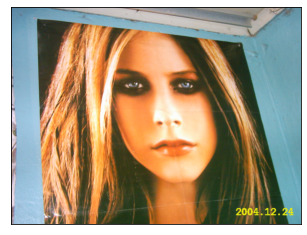


You look like a ... 
English toy spaniel


----------------------------------------------------------

Hello human!


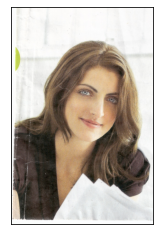


You look like a ... 
Chinese crested


----------------------------------------------------------

Hello human!


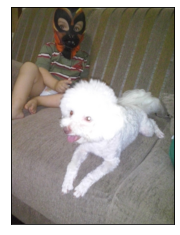


You look like a ... 
Bichon frise


----------------------------------------------------------


Hello, dog!


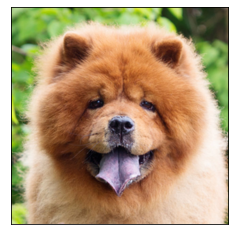


Your predicted breed is ... 
Chow chow


----------------------------------------------------------



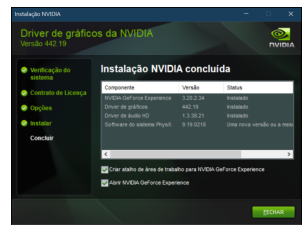


Not human nor dog


----------------------------------------------------------



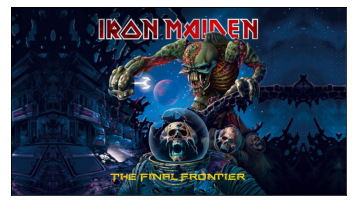


Not human nor dog


----------------------------------------------------------

Hello human!


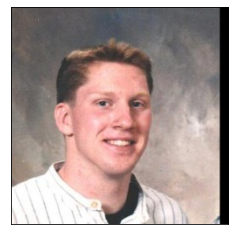


You look like a ... 
Pharaoh hound


----------------------------------------------------------

Hello human!


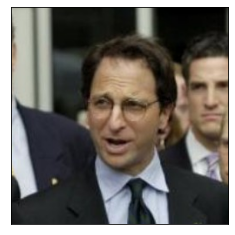


You look like a ... 
Dogue de bordeaux


----------------------------------------------------------


Hello, dog!


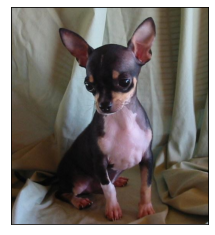


Your predicted breed is ... 
Chihuahua


----------------------------------------------------------


Hello, dog!


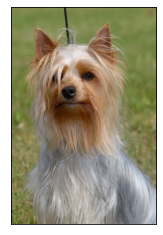


Your predicted breed is ... 
Chinese crested


----------------------------------------------------------



In [32]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

run_app('/content/AvrilLavigne.JPG')
run_app('/content/CapaRevista.jpg')
run_app('/content/Bob.jpg')
run_app('/content/chow_chow-p.jpg')
run_app('/content/DriverNvidia.png')
run_app('/content/IronMaiden_TheFinalFrontier.jpg')

human_pic = np.random.randint(0,len(human_files),2)
dog_pic = np.random.randint(0,len(dog_files),2)

for file in np.hstack((human_files[human_pic], dog_files[dog_pic])):
    run_app(file)